In [51]:
import os, sys
from pathlib import Path
import re
import json
import pickle
import pandas as pd
import numpy as np

import random
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score, PrecisionRecallDisplay, precision_recall_curve, auc

## Initialization

In [3]:
# G2 config
data_root = Path('/home/yl986/data')
result_root = data_root / 'protein_interaction/results'

hint_root = data_root / 'HINT/update_2024/outputs'
parsed_root = data_root / 'protein_interaction/parsed'

In [4]:
# # BioHPC config
# data_root = Path('/local/storage/yl986/data/')
# result_root = data_root / 'protein_interaction/results'

# # hint_root = Path('/local/storage/HINT/update_2024/outputs')
# hint_root = Path('/fs/cbsuhy01/storage/HINT/update_2024/outputs')  # server-02
# parsed_root = data_root / '/local/storage/yl986/data/protein_interaction/parsed'

## Load data

### Load label reference set if applicable

In [ ]:
# with open(parsed_root / 'ppi_label_reference.pkl', 'rb') as f:
#     ppi_label_ref_dict = pickle.load(f)

### Curate from scratch
#### General (nonstructural, unconstrained)

* Exclusion set

In [13]:
# interactions from BioGRID, IntAct, STRING
ppi_comb3 = pd.read_csv(parsed_root / 'cache/ppi_comb3_rev.tsv', sep='\t', dtype={'evidence_code': str, 'pubmed': str})
ppi_comb3[ppi_comb3['has_exp_evidence']].groupby('source')['ppi'].nunique()

/tmp/ipykernel_816014/555671923.py:2: DtypeWarning: Columns (8,9,10,12,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  ppi_comb3 = pd.read_csv(parsed_root / 'cache/ppi_comb3_rev.tsv', sep='\t', dtype={'evidence_code': str, 'pubmed': str})


source
biogrid    803819
intact     345914
string     461584
Name: ppi, dtype: int64

In [14]:
# Updated with revised HINT (2024.6.27)
ppi_comb4 = pd.read_csv(parsed_root / 'cache/ppi_comb4.csv', dtype={'evidence_code': str, 'gene_name1': str, 'gene_name2': str, 'pubmed': str})
ppi_comb4['source'].value_counts()

/tmp/ipykernel_816014/1942007293.py:2: DtypeWarning: Columns (4,5,9,11,12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  ppi_comb4 = pd.read_csv(parsed_root / 'cache/ppi_comb4.csv', dtype={'evidence_code': str, 'gene_name1': str, 'gene_name2': str, 'pubmed': str})


hint       848742
string     327205
biogrid    164496
intact       8047
Name: source, dtype: int64

* Positive set

In [15]:
hint_lcb24 = pd.read_csv(hint_root / 'HINT_format/taxa/HomoSapiens/HomoSapiens_lcb_hq.txt', sep='\t', dtype=str)
hint_lcb24['ppi'] = hint_lcb24.apply(lambda x: ':'.join(sorted([x['Uniprot_A'], x['Uniprot_B']])), axis=1)
hint_lcb24['ppi'].nunique()

44115

In [23]:
nonstr_exclusion = pd.concat([ppi_comb3[['ppi']], ppi_comb4[['ppi']]])['ppi'].drop_duplicates().tolist()
nonstr_pos = hint_lcb24['ppi'].drop_duplicates().tolist()

print(len(nonstr_exclusion), len(nonstr_pos))

1317161 44115


#### Complex-based (structural)

In [16]:
# ires_root = Path('/home/yl986/data/IRES/parsed_files/20240616')
ires_root = Path('/home/yl986/data/IRES/parsed_files/20241018')

In [17]:
# ires_human = pd.read_csv(data_root / 'protein_interaction/ires_human_all.csv')
ires_human = pd.read_csv(ires_root / 'ires_human_all.csv')
# ppi_by_pdb = pd.read_csv(data_root / 'protein_interaction/ppi_by_pdb_info.csv')
# ppi_by_pdb['ppi'] = ppi_by_pdb['ppi'].str.replace('_', ':')
ppi_by_pdb = pd.read_csv(ires_root / 'ppi_by_pdb_info.csv')

In [24]:
ppi_in_pdb = ppi_by_pdb['ppi'].drop_duplicates().tolist()
ppi_str = ires_human['ppi'].drop_duplicates().tolist()
print(len(ppi_in_pdb), len(ppi_str))

44447 13393


In [56]:
def assign_ppi_label(df_ppi, nonstr_pos, nonstr_ex, str_pos, ppi_in_pdb):
    df_ppi = df_ppi.copy()
    # non-structural label
    df_ppi['non_struct_label'] = -1
    df_ppi.loc[~df_ppi['ppi'].isin(nonstr_ex), 'non_struct_label'] = 0
    df_ppi.loc[df_ppi['ppi'].isin(nonstr_pos), 'non_struct_label'] = 1

    # structural label
    df_ppi['str_label'] = -1  # interactions not found in the same complex structure / no structural evidence
    df_ppi.loc[df_ppi['ppi'].isin(ppi_in_pdb), 'str_label'] = 0  # found in same complex
    df_ppi.loc[df_ppi['ppi'].isin(str_pos), 'str_label'] = 1  # structural evidence
    
    label_dict = {-1: 'unclear (exclude for analysis)', 0: 'non-interacting pairs', 1: 'HINT-binary-HQ-LC'}
    df_ppi['nonstr_label_name'] = df_ppi['non_struct_label'].apply(lambda x: label_dict.get(x, x))

    label_dict = {-1: 'not found in same PDB complex', 0: 'no physical interaction', 1: 'direct physical interaction'}
    df_ppi['str_label_name'] = df_ppi['str_label'].apply(lambda x: label_dict[x])
    
    return df_ppi

In [53]:
# with open(parsed_root / 'ppi_label_reference.pkl', 'wb') as f:
#     pickle.dump({'nonstr_pos': nonstr_pos, 'nonstr_exclusion': nonstr_exclusion, 'true_ppi_in_pdb': ppi_str, 'all_pair_in_pdb': ppi_in_pdb}, f)

### Load labeled data
(from `result_analysis1.ipynb`)

In [5]:
df_ppi_all = pd.read_csv(result_root / 'ppi_pred_with_label.csv')
df_ppi_all['ppi'].nunique()

3069

In [44]:
df_ppi_all.groupby('str_label')['ppi'].nunique()

str_label
-1    1545
 0     667
 1     857
Name: ppi, dtype: int64

In [45]:
df_ppi_all.groupby('non_struct_label')['ppi'].nunique()

non_struct_label
-1     998
 0     887
 1    1184
Name: ppi, dtype: int64

### Load AFM/AF3 metrics

In [31]:
df_af3 = pd.read_csv(result_root / 'af3_scores_202411.csv')

In [32]:
df_af3['ppi'].nunique()

2824

In [57]:
df_af3_labeled = assign_ppi_label(df_af3, nonstr_pos, nonstr_exclusion, ppi_str, ppi_in_pdb)

In [58]:
df_af3_labeled.columns

Index(['ppi', 'pDockQ', 'PPV', 'prot1', 'prot2', 'ipTM', 'iptm_ptm', 'pTM',
       'pLDDT', 'pAE', 'ranking_confidence', 'LIS', 'LIA', 'inter_pae',
       'inter_pae_select', 'iplddt_mean', 'iplddt_chain_a', 'iplddt_chain_b',
       'ipae_mean', 'ipae_chain_b', 'ipae_chain_a', 'pdockq2_mean',
       'non_struct_label', 'str_label', 'nonstr_label_name', 'str_label_name'],
      dtype='object')

In [252]:
df_af3_labeled['is_homo'] = df_af3_labeled['ppi'].apply(lambda x: len(set(x.split(':'))) == 1)

In [253]:
df_af3_labeled['is_homo'].value_counts()

False    2496
True      328
Name: is_homo, dtype: int64

In [42]:
df_af3_labeled.groupby('str_label')['ppi'].nunique()

str_label
-1    1412
 0     606
 1     806
Name: ppi, dtype: int64

In [43]:
df_af3_labeled.groupby('non_struct_label')['ppi'].nunique()

non_struct_label
-1     798
 0     908
 1    1118
Name: ppi, dtype: int64

In [254]:
df_af3_labeled[~df_af3_labeled['is_homo']].groupby('non_struct_label')['ppi'].nunique()

non_struct_label
-1    785
 0    844
 1    867
Name: ppi, dtype: int64

In [55]:
df_af3_labeled.query('non_struct_label != -1').groupby('non_struct_label')['pdockq2_mean'].describe()

,count,mean,std,min,25%,50%,75%,max
non_struct_label,,,,,,,,
0,908.0,0.034786,0.107220,0.007,0.009,0.010,0.01400,0.925
1,1118.0,0.166944,0.260158,0.007,0.010,0.017,0.21875,0.959


## Plot

### Histogram

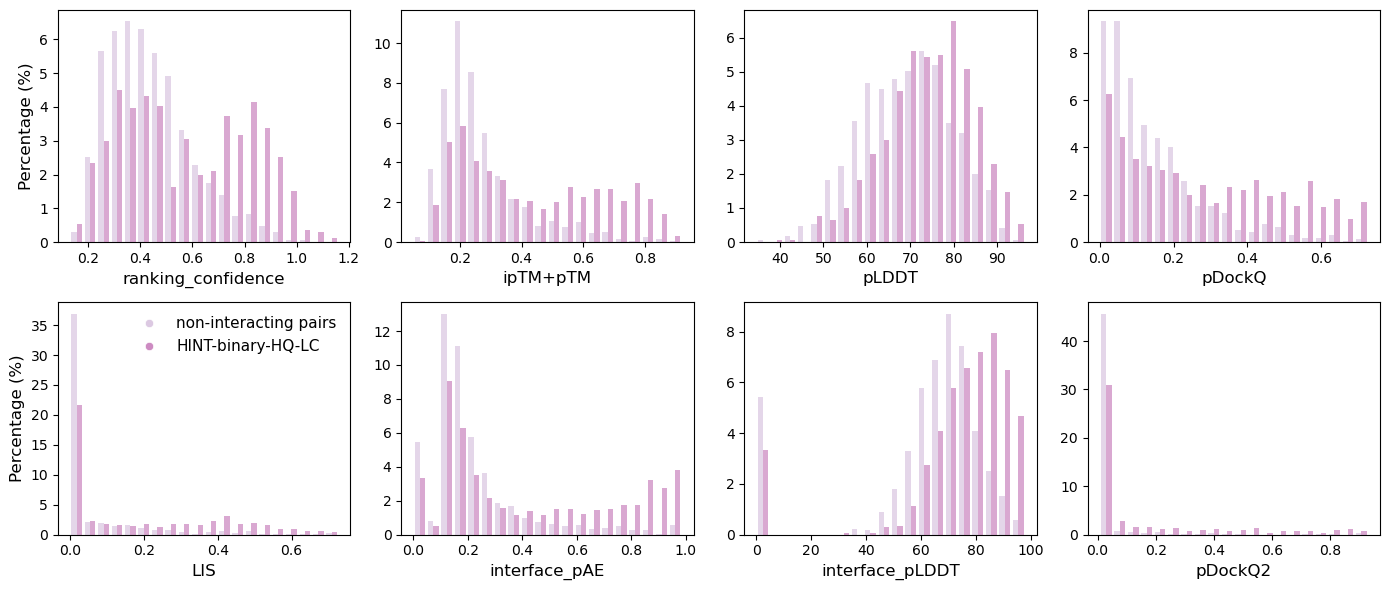

In [256]:
# cols = ['pTM', 'pLDDT', 'ipTM+pTM', 'pDockQ', 'LIS', 'pDockQ2']

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))
use_legend=False

palette = sns.color_palette('PuRd', 4)

# Plot KDE for each column on a separate subplot
cols = ['ranking_confidence', 'ipTM+pTM', 'pLDDT', 'pDockQ', 
        'LIS', 'interface_pAE', 'interface_pLDDT', 'pDockQ2']

df_non_struct = df_af3_labeled[~df_af3_labeled['is_homo']].query('non_struct_label != -1').sort_values('non_struct_label').\
                    rename(columns={'nonstr_label_name': 'label', 'iptm_ptm': 'ipTM+pTM', 'pdockq2_mean': 'pDockQ2', 
                                    'ipae_mean': 'interface_pAE', 'iplddt_mean': 'interface_pLDDT'})

# df_non_struct = df_af3_labeled.query('non_struct_label != -1').sort_values('non_struct_label').\
#                     rename(columns={'nonstr_label_name': 'label', 'iptm_ptm': 'ipTM+pTM', 'pdockq2_mean': 'pDockQ2'})
# df_struct_plt = afm_scores.query('str_label != -1').sort_values('str_label').rename(columns={'str_label_name': 'label', 'iptm_ptm': 'ipTM+pTM'})

r = 0
for i, metric in enumerate(cols):
    if i > 3:
        r = 1
    c = i % 4
    # if i == (len(cols)-1):
    if c == 0 and r == 1:
        sns.scatterplot(data=df_non_struct, x=metric, ax=axes[r][c], hue='label', legend='full', palette=[palette[0], palette[1]])
        # sns.scatterplot(data=df_struct_plt, x=metric, ax=axes[r][c], hue='label', legend='full', palette=sns.color_palette('rocket_r', 2))
        # axes[r][c].legend(loc='upper left', fontsize=11, frameon=False, handletextpad=0.1, bbox_to_anchor=(.01, 1))
        axes[r][c].legend(loc='upper right', fontsize=11, frameon=False,)
        
    # sns.kdeplot(data=df_non_struct, x=metric, ax=axes[r][c], hue='label', legend=False, palette=sns.color_palette('rocket_r', 2))
    sns.histplot(data=df_non_struct, x=metric, ax=axes[r][c], hue='label', legend=False, palette=[palette[0], palette[1]], 
                 multiple='dodge', shrink=0.8, bins=20, linewidth=0, stat='percent')
    # sns.histplot(data=df_non_struct, x=metric, ax=axes[r][c], hue='label', legend=False, palette=sns.color_palette('rocket_r', 2), multiple='dodge', shrink=0.8, bins=20, linewidth=0)
#     sns.kdeplot(data=df_struct_plt, x=metric, ax=axes[r][c], hue='label', legend=False, palette=sns.color_palette('BuPu', 2))
    axes[r][c].set_xlabel(metric, fontsize=12)
    # axes[i][0].legend(title='')
    # axes[0][i].set_title(f'{metric}:non-structural')
    if c > 0:
        axes[r][c].set_ylabel('')
    else:
        axes[r][c].set_ylabel('Percentage (%)', fontsize=12)

plt.tight_layout()

plt.savefig('./figures/af3_nonstr_hist_balance_2411_nonhomo.pdf', bbox_inches='tight')
# plt.savefig('./figures/afm_str_kde4.pdf', bbox_inches='tight')

### ROC

In [68]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

In [70]:
df_af3_labeled.columns

Index(['ppi', 'pDockQ', 'PPV', 'prot1', 'prot2', 'ipTM', 'iptm_ptm', 'pTM',
       'pLDDT', 'pAE', 'ranking_confidence', 'LIS', 'LIA', 'inter_pae',
       'inter_pae_select', 'iplddt_mean', 'iplddt_chain_a', 'iplddt_chain_b',
       'ipae_mean', 'ipae_chain_b', 'ipae_chain_a', 'pdockq2_mean',
       'non_struct_label', 'str_label', 'nonstr_label_name', 'str_label_name'],
      dtype='object')

In [257]:
df_af3_labeled[~df_af3_labeled['is_homo']].groupby('non_struct_label')['ppi'].nunique()

non_struct_label
-1    785
 0    844
 1    867
Name: ppi, dtype: int64

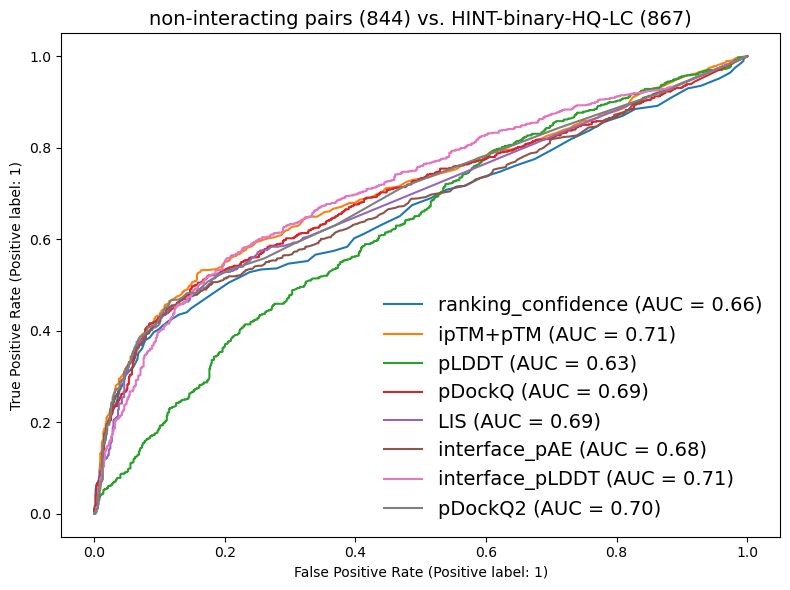

In [259]:
# negative = disease labels sampled from the same protein
# cols = ['pTM', 'pLDDT', 'ipTM+pTM', 'pDockQ', 'LIS']
# cols = ['ranking_confidence', 'pLDDT', 'ipTM+pTM', 'pDockQ', 'LIS', 'pDockQ2', 'interface_pAE', 'interface_pLDDT']
cols = ['ranking_confidence', 'ipTM+pTM', 'pLDDT', 'pDockQ', 
        'LIS', 'interface_pAE', 'interface_pLDDT', 'pDockQ2']

df_non_struct = df_af3_labeled[~df_af3_labeled['is_homo']].query('non_struct_label != -1').sort_values('non_struct_label').\
                    rename(columns={'nonstr_label_name': 'label', 'iptm_ptm': 'ipTM+pTM', 'pdockq2_mean': 'pDockQ2', 
                                    'ipae_mean': 'interface_pAE', 'iplddt_mean': 'interface_pLDDT'})

plt.figure(figsize=(8,6))
for metric in cols:
    RocCurveDisplay.from_predictions(
#         df_non_struct.query('non_struct_label < 2')['non_struct_label'], df_non_struct.query('non_struct_label < 2')[metric], ax=plt.gca(), name=metric
#         df_non_struct['is_hq_bin'], df_non_struct[metric], ax=plt.gca(), name=metric
        df_non_struct['non_struct_label'], df_non_struct[metric], ax=plt.gca(), name=metric
    )


plt.legend(frameon=False, fontsize=14)
# plt.xlabel('Recall', fontsize=14)
# plt.ylabel('Precision', fontsize=14)

# plt.ylim(0.4, 1)
leg = plt.gca().get_legend()
# plt.title('non-interacting pairs (-) vs. HINT-binary-HQ (+)', fontsize=14)
plt.title('non-interacting pairs (844) vs. HINT-binary-HQ-LC (867)', fontsize=14)
plt.tight_layout()
plt.savefig('./figures/af3_roc_nonstr_balance_241121_nonhomo.pdf', bbox_inches='tight')

### Precision-Recall

In [106]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, auc, average_precision_score

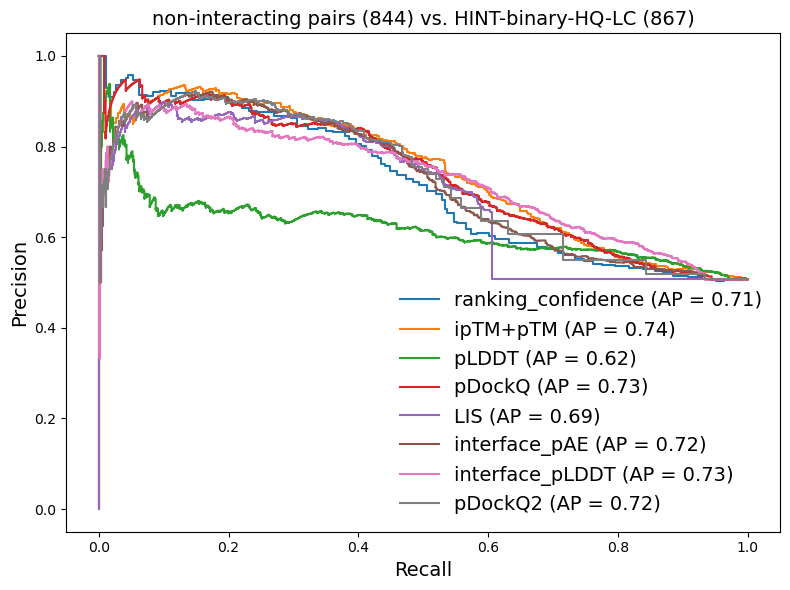

In [263]:
# negative = disease labels sampled from the same protein
# cols = ['pTM', 'pLDDT', 'ipTM+pTM', 'pDockQ', 'LIS']
# cols = ['ranking_confidence', 'pLDDT', 'ipTM+pTM', 'pDockQ', 'LIS', 'pDockQ2', 'interface_pAE', 'interface_pLDDT']
cols = ['ranking_confidence', 'ipTM+pTM', 'pLDDT', 'pDockQ', 
        'LIS', 'interface_pAE', 'interface_pLDDT', 'pDockQ2']

df_non_struct = df_af3_labeled[~df_af3_labeled['is_homo']].query('non_struct_label != -1').sort_values('non_struct_label').\
                    rename(columns={'nonstr_label_name': 'label', 'iptm_ptm': 'ipTM+pTM', 'pdockq2_mean': 'pDockQ2', 
                                    'ipae_mean': 'interface_pAE', 'iplddt_mean': 'interface_pLDDT'})

plt.figure(figsize=(8,6))
for metric in cols:
    PrecisionRecallDisplay.from_predictions(
#         df_non_struct.query('non_struct_label < 2')['non_struct_label'], df_non_struct.query('non_struct_label < 2')[metric], ax=plt.gca(), name=metric
#         df_non_struct['is_hq_bin'], df_non_struct[metric], ax=plt.gca(), name=metric
        df_non_struct['non_struct_label'], df_non_struct[metric], ax=plt.gca(), name=metric
    )


plt.legend(frameon=False, fontsize=14)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)

# plt.ylim(0.4, 1)
leg = plt.gca().get_legend()
# plt.title('non-interacting pairs (-) vs. HINT-binary-HQ (+)', fontsize=14)
plt.title('non-interacting pairs (844) vs. HINT-binary-HQ-LC (867)', fontsize=14)
plt.tight_layout()
plt.savefig('./figures/af3_pr_nonstr_balance_241121_nonhomo.pdf', bbox_inches='tight')

In [104]:
def get_auc_scores(df_scores, metrics, gt_col):
    # cols = ['ranking_confidence', 'ipTM+pTM', 'pLDDT', 'pDockQ', 'LIS', 'interface_pAE', 'interface_pLDDT', 'pDockQ2']
    auroc_dict = dict()
    aupr_dict = dict()

    # df_scores = df_af3_labeled.query('non_struct_label != -1')
    for metric in metrics:
        auroc_dict[metric] = roc_auc_score(df_scores[gt_col], df_scores[metric])
        p, r, _ = precision_recall_curve(df_scores[gt_col], df_scores[metric])
        aupr_dict[metric] = auc(r, p)
    
    return {'auroc': auroc_dict, 'aupr': aupr_dict}

In [105]:
metric_cols = ['ranking_confidence', 'iptm_ptm', 'pLDDT', 'pDockQ', 'LIS', 'ipae_mean', 'iplddt_mean', 'pdockq2_mean']

get_auc_scores(df_af3_labeled.query('non_struct_label != -1'), metric_cols, 'non_struct_label')

{'auroc': {'ranking_confidence': 0.6394063305304468,
  'iptm_ptm': 0.685912540486867,
  'pLDDT': 0.6096992150867266,
  'pDockQ': 0.7136573727471177,
  'LIS': 0.6755731206607142,
  'ipae_mean': 0.6747712639783123,
  'iplddt_mean': 0.7022535719070397,
  'pdockq2_mean': 0.6907473225473431},
 'aupr': {'ranking_confidence': 0.7290412212038336,
  'iptm_ptm': 0.7532461087787928,
  'pLDDT': 0.6447183969053822,
  'pDockQ': 0.7767540242995283,
  'LIS': 0.747403516536834,
  'ipae_mean': 0.7478165688806037,
  'iplddt_mean': 0.7490235190763295,
  'pdockq2_mean': 0.7561228379145298}}

In [264]:
get_auc_scores(df_af3_labeled.query('non_struct_label != -1 & is_homo == False'), metric_cols, 'non_struct_label')

{'auroc': {'ranking_confidence': 0.6615194028545346,
  'iptm_ptm': 0.7064863860236037,
  'pLDDT': 0.6251742403122387,
  'pDockQ': 0.6945184681065066,
  'LIS': 0.6869284234463231,
  'ipae_mean': 0.6765437008369002,
  'iplddt_mean': 0.7128061846428004,
  'pdockq2_mean': 0.6952577936666721},
 'aupr': {'ranking_confidence': 0.7170273279253736,
  'iptm_ptm': 0.7415561296897208,
  'pLDDT': 0.6186703997014296,
  'pDockQ': 0.7343029058388096,
  'LIS': 0.7228436810762102,
  'ipae_mean': 0.7178563708699481,
  'iplddt_mean': 0.7257823145499188,
  'pdockq2_mean': 0.7280221812810999}}

In [122]:
df_af3_labeled['non_struct_label'].value_counts().to_dict()

{1: 1118, 0: 908, -1: 798}

## Bootstrap

In [118]:
sum(df_af3_labeled['non_struct_label'] == 1)

1118

In [192]:
def bootstrap_resample(df_scores, metrics, gt_col, target_ratio=0.1, n_repeats=10, n_pos_sample=None):
    pos_mask = df_scores[gt_col] == 1
    neg_mask = df_scores[gt_col] == 0
    
    n_pos = sum(pos_mask)
    n_neg = sum(neg_mask)
    if not n_pos_sample:
        n_pos_sample = n_pos
    n_neg_sample = int(n_pos_sample / target_ratio)
    print(f'Initial {n_pos} positive, {n_neg} negative')
    auroc_lst = []
    aupr_lst = []
    neg_ind_all = []
    for i in range(n_repeats):
        pos_indices = np.random.choice(n_pos, size=n_pos_sample, replace=False)  # downsampling positive if necessary (without replacement)
        
        neg_indices = np.random.choice(n_neg, size=n_neg_sample, replace=True)  # sampling with replacement
        neg_ind_all.append(neg_indices)
        
        df_boot = pd.concat([df_scores[pos_mask].iloc[pos_indices], df_scores[neg_mask].iloc[neg_indices]]).reset_index(drop=True)
        if i == 0:
            print(df_boot[gt_col].value_counts().to_dict())
        res_dict = get_auc_scores(df_boot, metrics, gt_col)
        
        auroc_lst.append(res_dict['auroc'])
        aupr_lst.append(res_dict['aupr'])
    
    return auroc_lst, aupr_lst, neg_ind_all

In [273]:
metric_cols = ['ranking_confidence', 'iptm_ptm', 'pLDDT', 'pDockQ', 'LIS', 'ipae_mean', 'iplddt_mean', 'pdockq2_mean']

df_af3_nonhomo = df_af3_labeled.query('non_struct_label != -1 & is_homo == False').reset_index(drop=True)
auroc10_lst, aupr10_lst, neg_ind_all = bootstrap_resample(df_af3_nonhomo, metric_cols, 'non_struct_label', n_repeats=100)

Initial 867 positive, 844 negative
{0: 8670, 1: 867}


### Plot

#### auPR

In [274]:
aupr_boot = pd.DataFrame.from_dict(aupr10_lst)
aupr_boot.describe()

,ranking_confidence,iptm_ptm,pLDDT,pDockQ,LIS,ipae_mean,iplddt_mean,pdockq2_mean
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.272684,0.280350,0.146017,0.273867,0.243825,0.255078,0.239264,0.260497
std,0.007351,0.007801,0.002815,0.007101,0.006006,0.006472,0.006000,0.006631
min,0.252040,0.259894,0.139707,0.260611,0.228491,0.240313,0.224392,0.245301
25%,0.268138,0.275620,0.144095,0.268733,0.239634,0.250851,0.236198,0.256512
50%,0.273290,0.280169,0.146032,0.274507,0.243219,0.254088,0.238559,0.259431
75%,0.277188,0.285274,0.147830,0.278549,0.247992,0.260718,0.243472,0.266285
max,0.290912,0.300298,0.153628,0.294019,0.257990,0.271702,0.257482,0.276810


In [275]:
aupr_boot_long = pd.melt(aupr_boot, value_vars=aupr_boot.columns, var_name='metric', value_name='auPR')

In [276]:
metric_dict = {'iptm_ptm': 'ipTM+pTM', 'pdockq2_mean': 'pDockQ2', 'ipae_mean': 'interface_pAE', 'iplddt_mean': 'interface_pLDDT'}
aupr_boot_long['metric'] = aupr_boot_long['metric'].apply(lambda x: metric_dict.get(x, x))

In [277]:
aupr_boot_long['metric'].unique()

array(['ranking_confidence', 'ipTM+pTM', 'pLDDT', 'pDockQ', 'LIS',
       'interface_pAE', 'interface_pLDDT', 'pDockQ2'], dtype=object)

Text(0.5, 1.0, 'Positive-to-negative ratio 1:10 by oversampling\n(positive: 867, negative: 8670)')

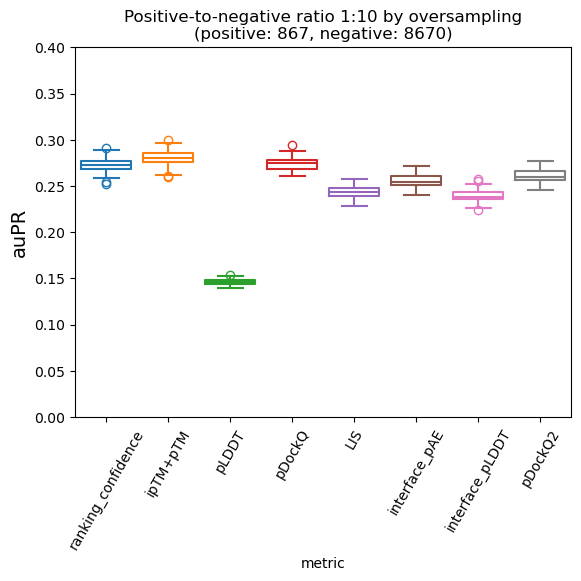

In [278]:
img = sns.boxplot(aupr_boot_long,x='metric', y='auPR', hue='metric', fill=False)
plt.setp(img.get_xticklabels(), rotation=60);
plt.ylim(0, 0.4)
plt.ylabel('auPR', fontsize=14)
plt.title('Positive-to-negative ratio 1:10 by oversampling\n(positive: 867, negative: 8670)')

# plt.savefig('./figures/af3_box_aupr_nonstr_neg10_241121.pdf', bbox_inches='tight')

#### Histogram
* select one bootstrap result to explore score distribution

In [279]:
pos_mask = df_af3_nonhomo['non_struct_label'] == 1
neg_mask = df_af3_nonhomo['non_struct_label'] == 0

df_boot0 = pd.concat([df_af3_nonhomo[pos_mask], df_af3_nonhomo[neg_mask].iloc[neg_ind_all[0]]]).reset_index(drop=True)

In [280]:
df_boot0.query('non_struct_label == 0')['ppi'].value_counts()

Q7RTT3:Q8NFX7    22
O60676:Q8IWX5    21
Q68D20:Q9NQF3    19
P62847:P39019    19
Q6FHJ7:Q8N8H1    18
                 ..
P08887:Q96DD0     3
Q9H2H0:Q9UPC5     2
P46782:P46781     2
Q6IEE8:Q9NNZ6     1
Q8N5D6:Q8WVP7     1
Name: ppi, Length: 844, dtype: int64

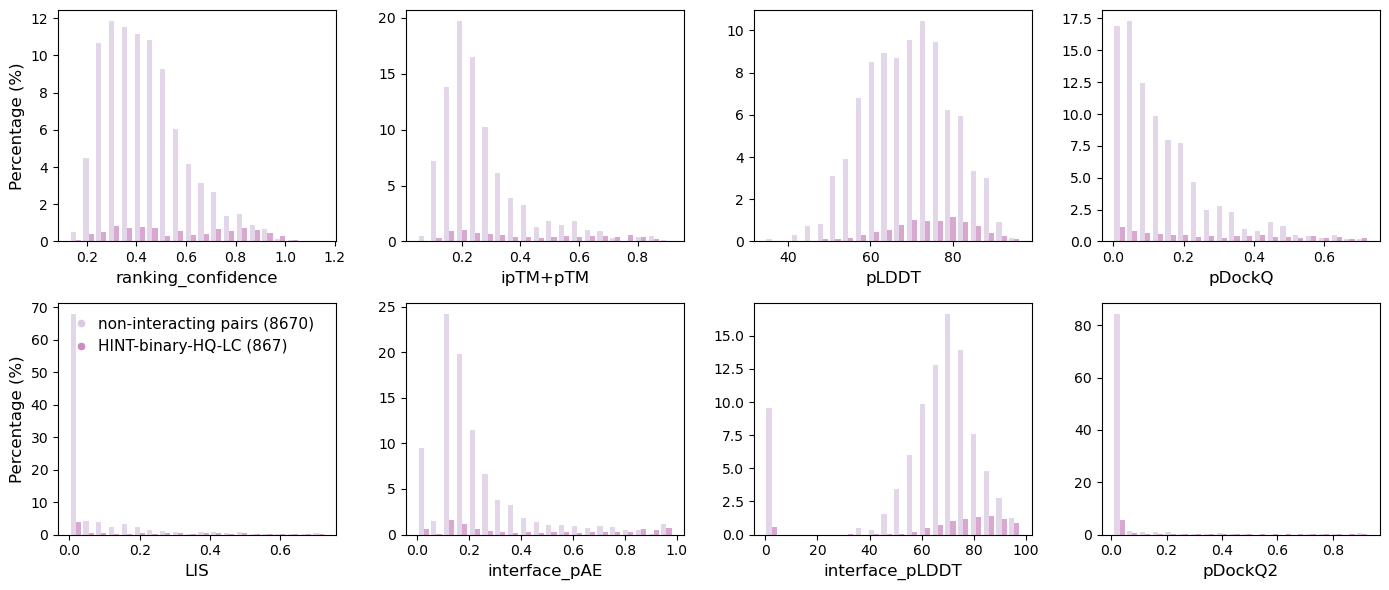

In [281]:
# cols = ['pTM', 'pLDDT', 'ipTM+pTM', 'pDockQ', 'LIS', 'pDockQ2']

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))
use_legend=False

palette = sns.color_palette('PuRd', 4)

# Plot KDE for each column on a separate subplot
cols = ['ranking_confidence', 'ipTM+pTM', 'pLDDT', 'pDockQ', 
        'LIS', 'interface_pAE', 'interface_pLDDT', 'pDockQ2']

df_boot_plt = df_boot0.query('non_struct_label != -1').sort_values('non_struct_label').\
                    rename(columns={'nonstr_label_name': 'label', 'iptm_ptm': 'ipTM+pTM', 'pdockq2_mean': 'pDockQ2', 
                                    'ipae_mean': 'interface_pAE', 'iplddt_mean': 'interface_pLDDT'})

relabel_dict = {k: '{} ({})'.format(k, v) for k, v in df_boot_plt['label'].value_counts().to_dict().items()}
df_boot_plt['label'] = df_boot_plt['label'].apply(lambda x: relabel_dict[x])


r = 0
for i, metric in enumerate(cols):
    if i > 3:
        r = 1
    c = i % 4
    # if i == (len(cols)-1):
    if c == 0 and r == 1:
        sns.scatterplot(data=df_boot_plt, x=metric, ax=axes[r][c], hue='label', legend='full', palette=[palette[0], palette[1]])
        # sns.scatterplot(data=df_struct_plt, x=metric, ax=axes[r][c], hue='label', legend='full', palette=sns.color_palette('rocket_r', 2))
        axes[r][c].legend(loc='upper left', fontsize=11, frameon=False, handletextpad=0.08, bbox_to_anchor=(-0.02, 1))
        # axes[r][c].legend(loc='upper right', fontsize=11, frameon=False,)
        
    # sns.kdeplot(data=df_non_struct, x=metric, ax=axes[r][c], hue='label', legend=False, palette=sns.color_palette('rocket_r', 2))
    sns.histplot(data=df_boot_plt, x=metric, ax=axes[r][c], hue='label', legend=False, palette=[palette[0], palette[1]], 
                 multiple='dodge', shrink=0.8, bins=20, linewidth=0, stat='percent')
    # sns.histplot(data=df_non_struct, x=metric, ax=axes[r][c], hue='label', legend=False, palette=sns.color_palette('rocket_r', 2), multiple='dodge', shrink=0.8, bins=20, linewidth=0)
#     sns.kdeplot(data=df_struct_plt, x=metric, ax=axes[r][c], hue='label', legend=False, palette=sns.color_palette('BuPu', 2))
    axes[r][c].set_xlabel(metric, fontsize=12)
    # axes[i][0].legend(title='')
    # axes[0][i].set_title(f'{metric}:non-structural')
    if c > 0:
        axes[r][c].set_ylabel('')
    else:
        axes[r][c].set_ylabel('Percentage (%)', fontsize=12)

plt.tight_layout()

plt.savefig('./figures/af3_nonstr_hist_neg10_boot_2411_nonhomo.pdf', bbox_inches='tight')
# plt.savefig('./figures/afm_str_kde4.pdf', bbox_inches='tight')

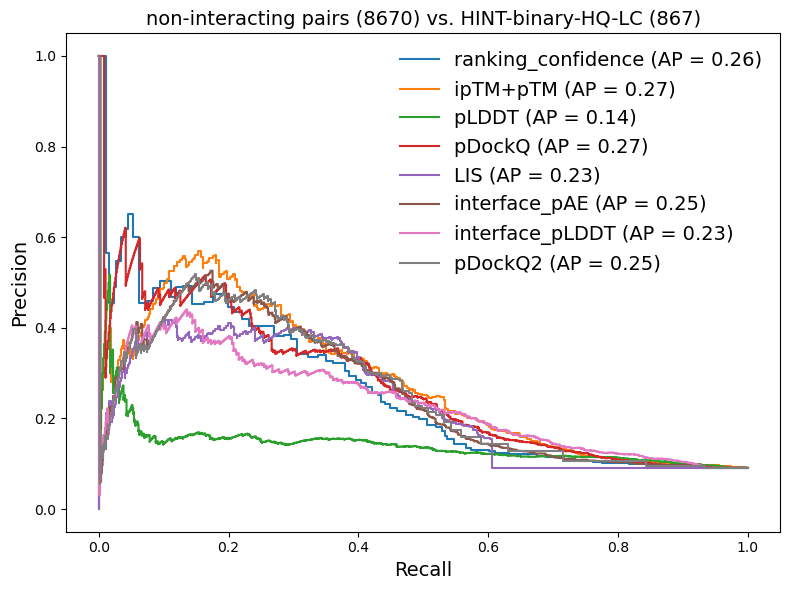

In [282]:
cols = ['ranking_confidence', 'ipTM+pTM', 'pLDDT', 'pDockQ', 
        'LIS', 'interface_pAE', 'interface_pLDDT', 'pDockQ2']

df_boot_plt = df_boot0.query('non_struct_label != -1').sort_values('non_struct_label').\
                    rename(columns={'nonstr_label_name': 'label', 'iptm_ptm': 'ipTM+pTM', 'pdockq2_mean': 'pDockQ2', 
                                    'ipae_mean': 'interface_pAE', 'iplddt_mean': 'interface_pLDDT'})

plt.figure(figsize=(8,6))
for metric in cols:
    PrecisionRecallDisplay.from_predictions(
#         df_non_struct.query('non_struct_label < 2')['non_struct_label'], df_non_struct.query('non_struct_label < 2')[metric], ax=plt.gca(), name=metric
#         df_non_struct['is_hq_bin'], df_non_struct[metric], ax=plt.gca(), name=metric
        df_boot_plt['non_struct_label'], df_boot_plt[metric], ax=plt.gca(), name=metric
    )


plt.legend(frameon=False, fontsize=14)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)

# plt.ylim(0.4, 1)
leg = plt.gca().get_legend()
plt.title('non-interacting pairs (8670) vs. HINT-binary-HQ-LC (867)', fontsize=14)
plt.tight_layout()
plt.savefig('./figures/af3_pr_nonstr_over_neg10_241121_nonhomo.pdf', bbox_inches='tight')

## Downsampling

In [193]:
def downsample_and_eval(df_scores, metrics, gt_col, target_ratio=0.1, n_repeats=10):
    pos_mask = df_scores[gt_col] == 1
    neg_mask = df_scores[gt_col] == 0
    
    n_pos = sum(pos_mask)
    n_neg = sum(neg_mask)
    
    n_pos_sample = int(n_neg * target_ratio)
    print(f'Initial {n_pos} positive, {n_neg} negative, sample {n_pos_sample} positives')
    auroc_lst = []
    aupr_lst = []
    pos_ind_all = []
    for i in range(n_repeats):
        pos_indices = np.random.choice(n_pos, size=n_pos_sample, replace=True)  # sampling with replacement
        pos_ind_all.append(pos_indices)
        
        df_boot = pd.concat([df_scores[pos_mask].iloc[pos_indices], df_scores[neg_mask]]).reset_index(drop=True)
        if i == 0:
            print(df_boot[gt_col].value_counts().to_dict())
        res_dict = get_auc_scores(df_boot, metrics, gt_col)
        
        auroc_lst.append(res_dict['auroc'])
        aupr_lst.append(res_dict['aupr'])
    
    return auroc_lst, aupr_lst, pos_ind_all

In [283]:
metric_cols = ['ranking_confidence', 'iptm_ptm', 'pLDDT', 'pDockQ', 'LIS', 'ipae_mean', 'iplddt_mean', 'pdockq2_mean']

down_auroc10_lst, down_aupr10_lst, pos_ind_all = downsample_and_eval(df_af3_nonhomo.query('non_struct_label != -1'), metric_cols, 'non_struct_label', n_repeats=100)

Initial 867 positive, 844 negative, sample 84 positives
{0: 844, 1: 84}


In [284]:
aupr_sub = pd.DataFrame.from_dict(down_aupr10_lst)
aupr_sub.describe()

,ranking_confidence,iptm_ptm,pLDDT,pDockQ,LIS,ipae_mean,iplddt_mean,pdockq2_mean
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.265966,0.278205,0.143235,0.274160,0.244359,0.254667,0.237082,0.260126
std,0.045802,0.039541,0.021011,0.042520,0.035121,0.039622,0.034900,0.039314
min,0.163878,0.188311,0.104147,0.165773,0.170262,0.178047,0.159686,0.177233
25%,0.233858,0.249361,0.126308,0.247917,0.222256,0.225970,0.211495,0.230515
50%,0.268444,0.277011,0.142499,0.272698,0.244247,0.257183,0.238344,0.261516
75%,0.291724,0.300661,0.153632,0.304205,0.262945,0.276273,0.261051,0.280165
max,0.375183,0.386329,0.201873,0.391237,0.335268,0.374968,0.316973,0.379035


### Plot

In [285]:
aupr_sub_long = pd.melt(aupr_sub, value_vars=aupr_sub.columns, var_name='metric', value_name='auPR')

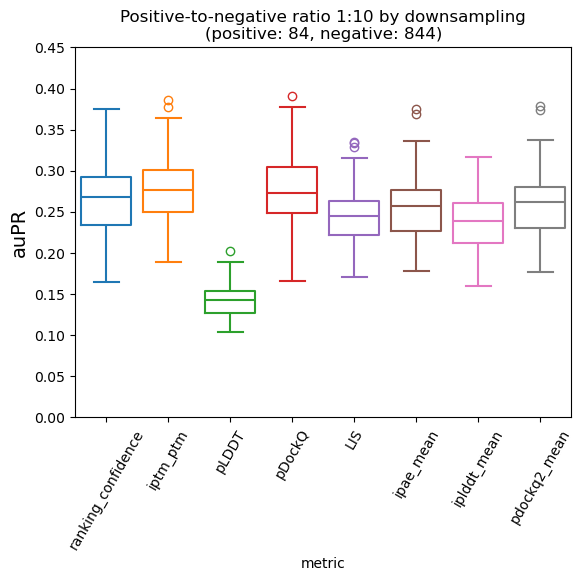

In [287]:
img = sns.boxplot(aupr_sub_long,x='metric', y='auPR', hue='metric', fill=False)
plt.setp(img.get_xticklabels(), rotation=60);
plt.ylabel('auPR', fontsize=14)
plt.ylim(0, 0.45)
plt.title('Positive-to-negative ratio 1:10 by downsampling\n(positive: 84, negative: 844)')
plt.savefig('./figures/af3_box_aupr_nonstr_neg10_down_241121_nonhomo.pdf', bbox_inches='tight')

### Example

In [289]:
pos_mask = df_af3_nonhomo['non_struct_label'] == 1
neg_mask = df_af3_nonhomo['non_struct_label'] == 0

df_sub0 = pd.concat([df_af3_nonhomo[pos_mask].iloc[pos_ind_all[1]], df_af3_nonhomo[neg_mask]]).reset_index(drop=True)

In [290]:
df_sub0['non_struct_label'].value_counts()

0    844
1     84
Name: non_struct_label, dtype: int64

#### Histogram

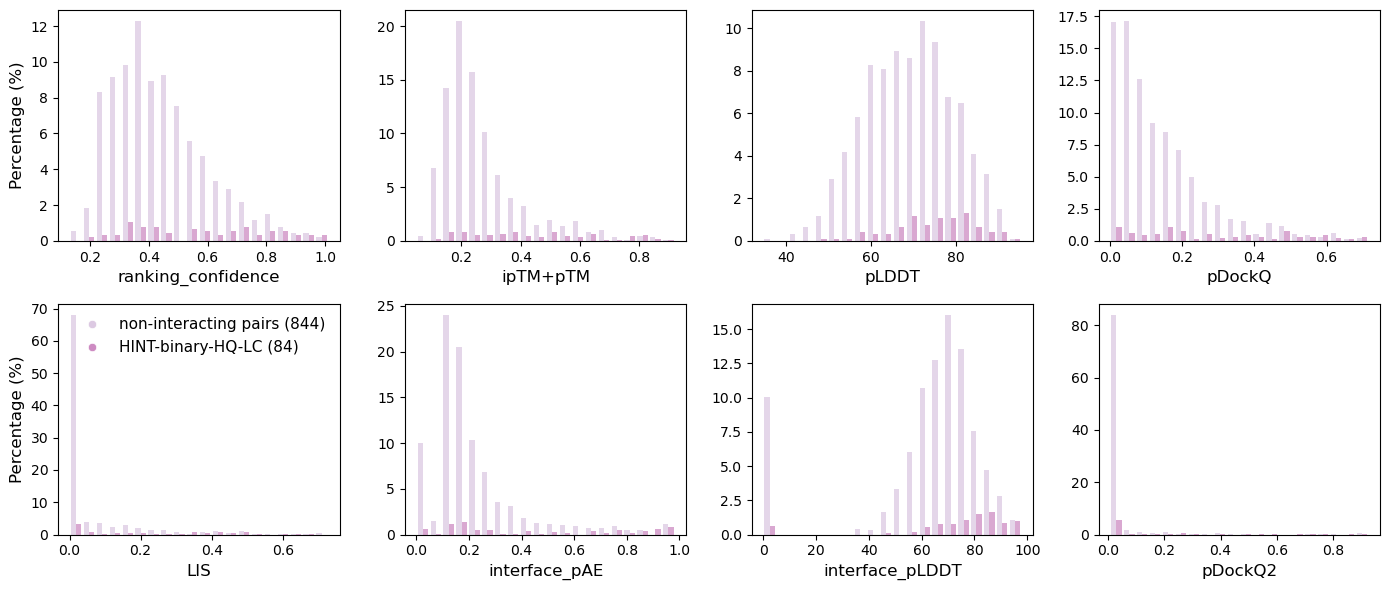

In [291]:
# cols = ['pTM', 'pLDDT', 'ipTM+pTM', 'pDockQ', 'LIS', 'pDockQ2']

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))
use_legend=False

palette = sns.color_palette('PuRd', 4)

# Plot KDE for each column on a separate subplot
cols = ['ranking_confidence', 'ipTM+pTM', 'pLDDT', 'pDockQ', 
        'LIS', 'interface_pAE', 'interface_pLDDT', 'pDockQ2']

df_sub_plt = df_sub0.query('non_struct_label != -1').sort_values('non_struct_label').\
                    rename(columns={'nonstr_label_name': 'label', 'iptm_ptm': 'ipTM+pTM', 'pdockq2_mean': 'pDockQ2', 
                                    'ipae_mean': 'interface_pAE', 'iplddt_mean': 'interface_pLDDT'})
relabel_dict = {k: '{} ({})'.format(k, v) for k, v in df_sub_plt['label'].value_counts().to_dict().items()}
df_sub_plt['label'] = df_sub_plt['label'].apply(lambda x: relabel_dict[x])

r = 0
for i, metric in enumerate(cols):
    if i > 3:
        r = 1
    c = i % 4
    # if i == (len(cols)-1):
    if c == 0 and r == 1:
        sns.scatterplot(data=df_sub_plt, x=metric, ax=axes[r][c], hue='label', legend='full', palette=[palette[0], palette[1]])
        # sns.scatterplot(data=df_struct_plt, x=metric, ax=axes[r][c], hue='label', legend='full', palette=sns.color_palette('rocket_r', 2))
        # axes[r][c].legend(loc='upper left', fontsize=11, frameon=False, handletextpad=0.1, bbox_to_anchor=(.01, 1))
        axes[r][c].legend(loc='upper right', fontsize=11, frameon=False,)
        
    # sns.kdeplot(data=df_non_struct, x=metric, ax=axes[r][c], hue='label', legend=False, palette=sns.color_palette('rocket_r', 2))
    sns.histplot(data=df_sub_plt, x=metric, ax=axes[r][c], hue='label', legend=False, palette=[palette[0], palette[1]], 
                 multiple='dodge', shrink=0.8, bins=20, linewidth=0, stat='percent')
    # sns.histplot(data=df_non_struct, x=metric, ax=axes[r][c], hue='label', legend=False, palette=sns.color_palette('rocket_r', 2), multiple='dodge', shrink=0.8, bins=20, linewidth=0)
#     sns.kdeplot(data=df_struct_plt, x=metric, ax=axes[r][c], hue='label', legend=False, palette=sns.color_palette('BuPu', 2))
    axes[r][c].set_xlabel(metric, fontsize=12)
    # axes[i][0].legend(title='')
    # axes[0][i].set_title(f'{metric}:non-structural')
    if c > 0:
        axes[r][c].set_ylabel('')
    else:
        axes[r][c].set_ylabel('Percentage (%)', fontsize=12)

plt.tight_layout()

plt.savefig('./figures/af3_nonstr_hist_neg10_sub_2411_nonhomo.pdf', bbox_inches='tight')
# plt.savefig('./figures/afm_str_kde4.pdf', bbox_inches='tight')

#### PR curve

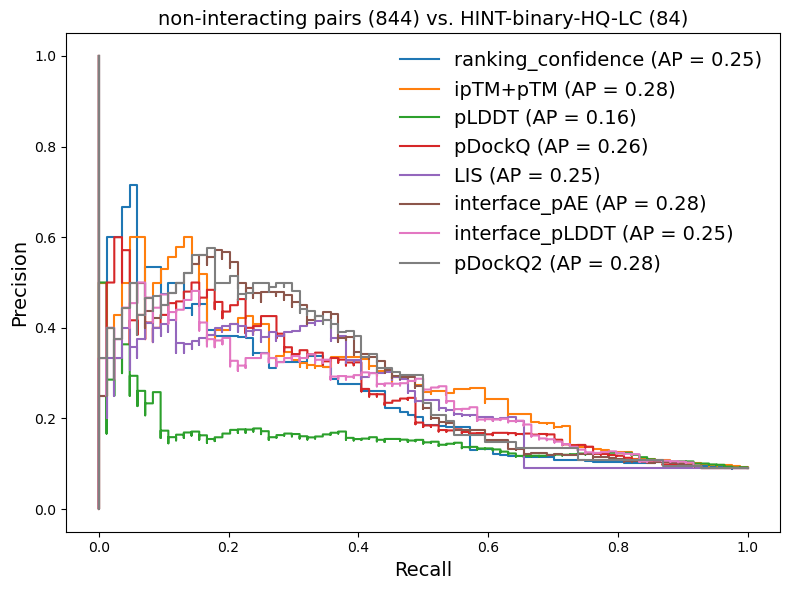

In [294]:
cols = ['ranking_confidence', 'ipTM+pTM', 'pLDDT', 'pDockQ', 
        'LIS', 'interface_pAE', 'interface_pLDDT', 'pDockQ2']

df_sub_plt = df_sub0.query('non_struct_label != -1').sort_values('non_struct_label').\
                    rename(columns={'nonstr_label_name': 'label', 'iptm_ptm': 'ipTM+pTM', 'pdockq2_mean': 'pDockQ2', 
                                    'ipae_mean': 'interface_pAE', 'iplddt_mean': 'interface_pLDDT'})

plt.figure(figsize=(8,6))
for metric in cols:
    PrecisionRecallDisplay.from_predictions(
        df_sub_plt['non_struct_label'], df_sub_plt[metric], ax=plt.gca(), name=metric
    )


plt.legend(frameon=False, fontsize=14)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)

# plt.ylim(0.4, 1)
leg = plt.gca().get_legend()
plt.title('non-interacting pairs (844) vs. HINT-binary-HQ-LC (84)', fontsize=14)
plt.tight_layout()
plt.savefig('./figures/af3_pr_nonstr_down_neg10_241121_nonhomo.pdf', bbox_inches='tight')